In [52]:
%reload_ext autoreload
%autoreload 2

In [53]:
import numpy as np
from obp.dataset import linear_reward_function
from obp.dataset import (SyntheticBanditDatasetWithActionEmbeds, 
                        linear_reward_function)
from obp.ope import RegressionModel
from ope import run_ope
import pandas as pd
from pandas import DataFrame
from policy import gen_eps_greedy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tqdm import tqdm

import conf

from regression_model import RegressionModelMDR

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from plots import plot_line

In [54]:
x = "n_action"
xlabel = "number of actions"

# fastest
n_seeds = 4
n_test = 100
n_train = 500
n_actions_list = [10, 20]

# # faster
# n_seeds = 4
# n_test = 1000
# n_train = 5000
# n_actions_list = [10, 20, 50, 100]

# n_actions_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]



result_df_list = []
for n_action in n_actions_list:
    ## define a dataset class
    # change the list to the action list
    estimated_policy_value_list = []

    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_action,
        dim_context=conf.dim_context,
        beta=conf.beta,
        reward_type=conf.reward_type,
        # Number of categories (cardinality) per each category dimension
        n_cat_per_dim=conf.n_cat_per_dim, 
        latent_param_mat_dim=conf.latent_param_mat_dim, 
        # Number of action/item category dimensions.
        n_cat_dim=conf.n_cat_dim,
        n_unobserved_cat_dim=conf.n_unobserved_cat_dim,
        n_deficient_actions=conf.n_deficient_actions,
        reward_function=conf.reward_function,
        reward_std=conf.reward_std,
        random_state=conf.random_state,
    )
    
    
    ### test bandit data is used to approximate the ground-truth policy value
    test_bandit_data = dataset.obtain_batch_bandit_feedback(
        n_rounds=n_test
        )

    # Generate an evaluation policy via the epsilon-greedy rule
    action_dist_test = gen_eps_greedy(
        expected_reward=test_bandit_data["expected_reward"],
        is_optimal=True,
        eps=conf.eps,
    )

    # actulal policy value e.g., 0.26909277388815384
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_bandit_data["expected_reward"],
        action_dist=action_dist_test,
    )
    
    
    
    for _ in tqdm(range(n_seeds), desc = f"n_action: {n_action}"):
        ## generate validation data
        val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=n_train
            )

        ## make decisions on validation data
        action_dist_val = gen_eps_greedy(
            expected_reward=val_bandit_data["expected_reward"],
            is_optimal=True,
            eps=conf.eps,
        )

        ## OPE using validation data
        
        # Machine learning model to estimate the reward function (:math:`q(x,a):= \mathbb{E}[r|x,a]`).
        reg_model = RegressionModel(
            # Number of actions.
            n_actions=dataset.n_actions,
            # Context vectors characterizing actions (i.e., a vector representation or an embedding of each action).
            action_context=val_bandit_data["action_context"],
            # A machine learning model used to estimate the reward function.
            base_model=RandomForestRegressor(
                n_estimators=10,
                max_samples=0.8,
                random_state=12345 + _
            ),
        )

        # Fit the regression model on given logged bandit data and estimate the expected rewards on the same data.
        # Returns
        #  q_hat: array-like, shape (n_rounds, n_actions, len_list)
        #  Expected rewards of new data estimated by the regression model.
        estimated_rewards = reg_model.fit_predict(
            context=val_bandit_data["context"],  # context; x
            action=val_bandit_data["action"],  # action; a
            reward=val_bandit_data["reward"],  # reward; r
            # Number of folds in the cross-fitting procedure.
            n_folds=2,
            random_state=12345 + _
        )
        
        # get the estimated values of several estimators e.g., DM, IPS, DR, MIPS
        estimated_policy_values = run_ope(
            # observed data D
            val_bandit_data=val_bandit_data,
            # evaluation policy \pi(a|x)
            action_dist_val=action_dist_val,
            # \hat{q(x, a)}
            estimated_rewards=estimated_rewards,
            embed_selection=False,
        )
        
        # DM estimator
        V_DM = np.mean(np.sum(action_dist_val * estimated_rewards, axis = 1))


        # MIPS
        # P(e|x, a) transition kernel
        p_e_a = val_bandit_data["p_e_a"]
        # behavior policy \pi_b(a|x) and evaluation policy \pi_e(a|x)
        # change the shape of them so that we can do matrix multiplication later
        pi_b = np.zeros((len(val_bandit_data["pi_b"]), len(val_bandit_data["pi_b"][0])))
        action_dist = np.zeros((len(val_bandit_data["pi_b"]), len(val_bandit_data["pi_b"][0])))
        for i in range(len(val_bandit_data["pi_b"])):
            for j in range(len(val_bandit_data["pi_b"][0])):
                pi_b[i][j] = val_bandit_data["pi_b"][i][j][0]
                action_dist[i][j] = action_dist_val[i][j][0]
        # n
        n = val_bandit_data["n_rounds"]
        # e
        action_embed = val_bandit_data["action_embed"]
        # initialize P(e|x, pi_b) and P(e|x, pi_e) by 1
        p_e_pi_b = np.ones(n)
        p_e_pi_e = np.ones(n)
        # for each d in [0, 1, 2, \cdots, d_e - 1]
        for d in np.arange(p_e_a.shape[-1]):
            # P(e|x, pi_b)
            p_e_pi_b_d = pi_b[np.arange(n), :] @ p_e_a[:, :, d]
            p_e_pi_b *= p_e_pi_b_d[np.arange(n), action_embed[:, d]]
            # P(e|x, pi_e)
            p_e_pi_e_d = action_dist[np.arange(n), :] @ p_e_a[:, :, d]
            p_e_pi_e *= p_e_pi_e_d[np.arange(n), action_embed[:, d]]
        # marginalize importance weight w(x_i, e_i)
        w_x_e = p_e_pi_e / p_e_pi_b

        V_MIPS = np.mean(w_x_e * val_bandit_data["reward"])

        estimated_policy_values["MIPS"] = V_MIPS

        
        # MDR
        # Machine learning model to estimate the reward function (:math:`q(x,a):= \mathbb{E}[r|x,a]`).
        reg_model_mdr = RegressionModelMDR(
            # Number of actions.
            n_actions=dataset.n_actions,
            # Context vectors characterizing actions (i.e., a vector representation or an embedding of each action).
            action_context=val_bandit_data["action_context"],
            # A machine learning model used to estimate the reward function.
            base_model=RandomForestRegressor(
                n_estimators=10,
                max_samples=0.8,
                random_state=12345 + _
            ),
        )

        # Fit the regression model on given logged bandit data and estimate the expected rewards on the same data.
        # Returns
        #  q_hat: array-like, shape (n_rounds, n_actions, len_list)
        #  Expected rewards of new data estimated by the regression model.
        estimated_rewards_mdr = reg_model_mdr.fit_predict(
            context=val_bandit_data["context"],  # context; x
            action=val_bandit_data["action"],  # action; a
            embedding=val_bandit_data["action_embed"], 
            reward=val_bandit_data["reward"],  # reward; r
            # Number of folds in the cross-fitting procedure.
            n_folds=2,
            random_state=12345 + _
        )

        q_xi_ai_ei = estimated_rewards_mdr[np.arange(val_bandit_data["n_rounds"]), val_bandit_data["action"]]
            
        # MDR
        # This is the MDR that I propose in the paper
        V_MDR = V_DM + V_MIPS - np.mean(w_x_e * q_xi_ai_ei)
               
        
        # add MDR to the dictionary of estimator and estimated value 
        # estimated_policy_values["MDR1"] = V_MDR1
        estimated_policy_values["MDR"] = V_MDR
        
        estimated_policy_value_list.append(estimated_policy_values)

    
    
    ## summarize results
    result_df = (
        DataFrame(DataFrame(estimated_policy_value_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "est", 0: "value"})
    )
    result_df["n_action"] = n_action
    result_df["se"] = (result_df.value - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
    for est_ in sample_mean["est"]:
        estimates = result_df.loc[result_df["est"] == est_, "value"].values
        mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
        mean_estimates = np.ones_like(estimates) * mean_estimates
        result_df.loc[result_df["est"] == est_, "bias"] = (
            policy_value - mean_estimates
        ) ** 2
        result_df.loc[result_df["est"] == est_, "variance"] = (
            estimates - mean_estimates
        ) ** 2
    result_df_list.append(result_df)


# aggregate all results
result_df = pd.concat(result_df_list).reset_index(level=0)

n_action: 20: 100%|██████████| 4/4 [00:00<00:00,  9.32it/s]


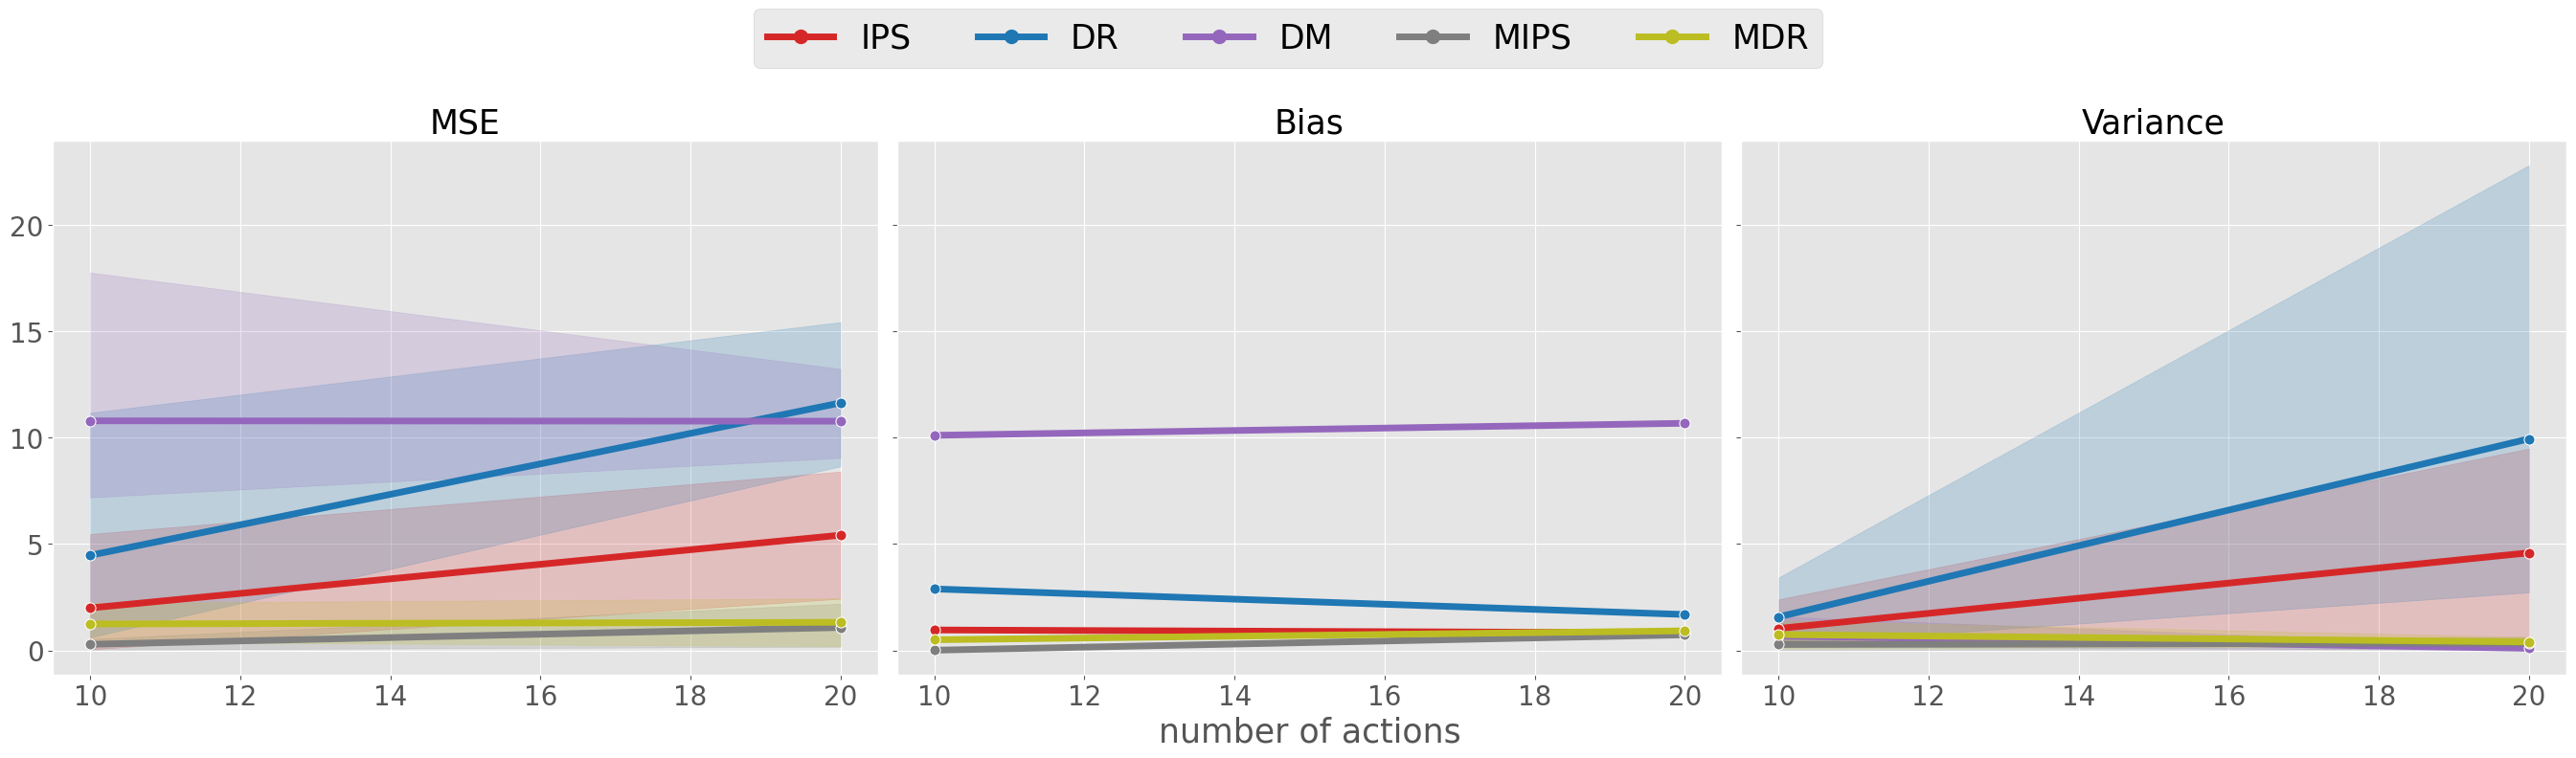

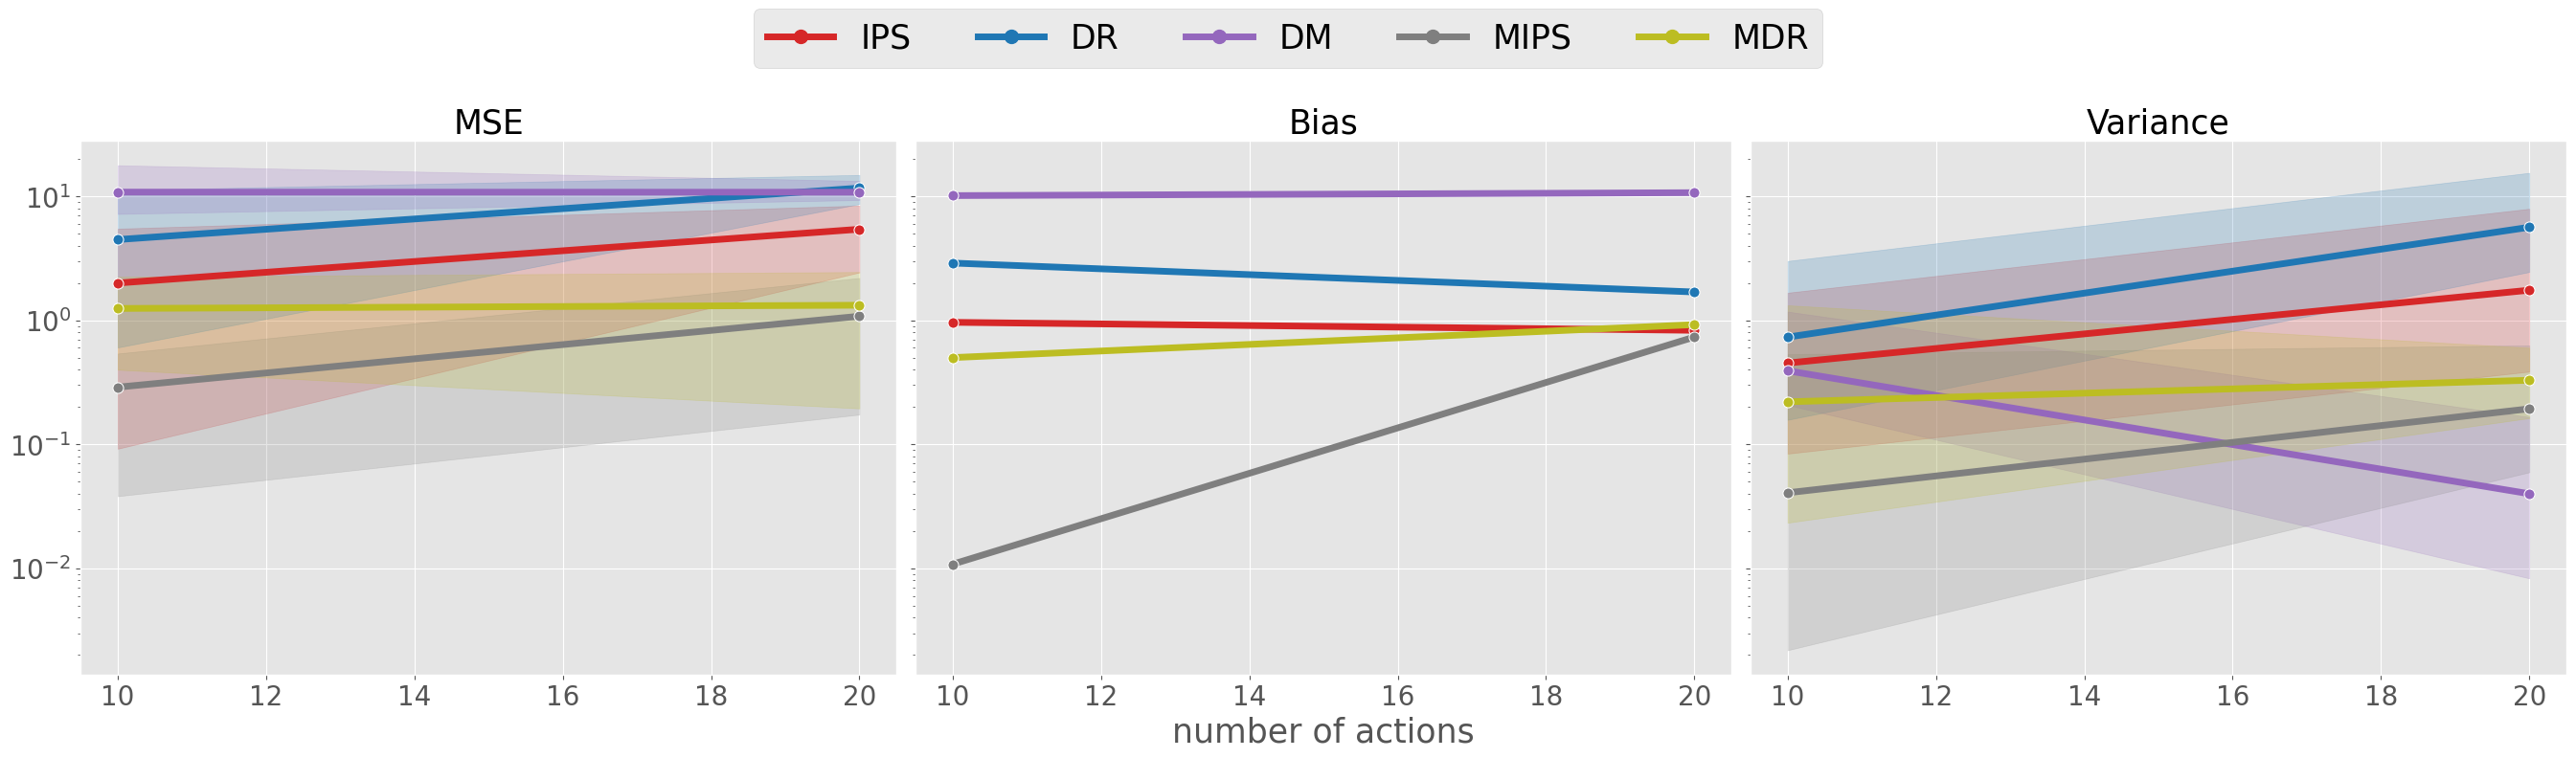

In [55]:
for flag_log_scale in [False, True]:
    plot_line(
        result_df = result_df, 
        x = x, 
        xlabel = xlabel, 
        flag_log_scale=flag_log_scale, 
        flag_share_y_scale=True,
    )

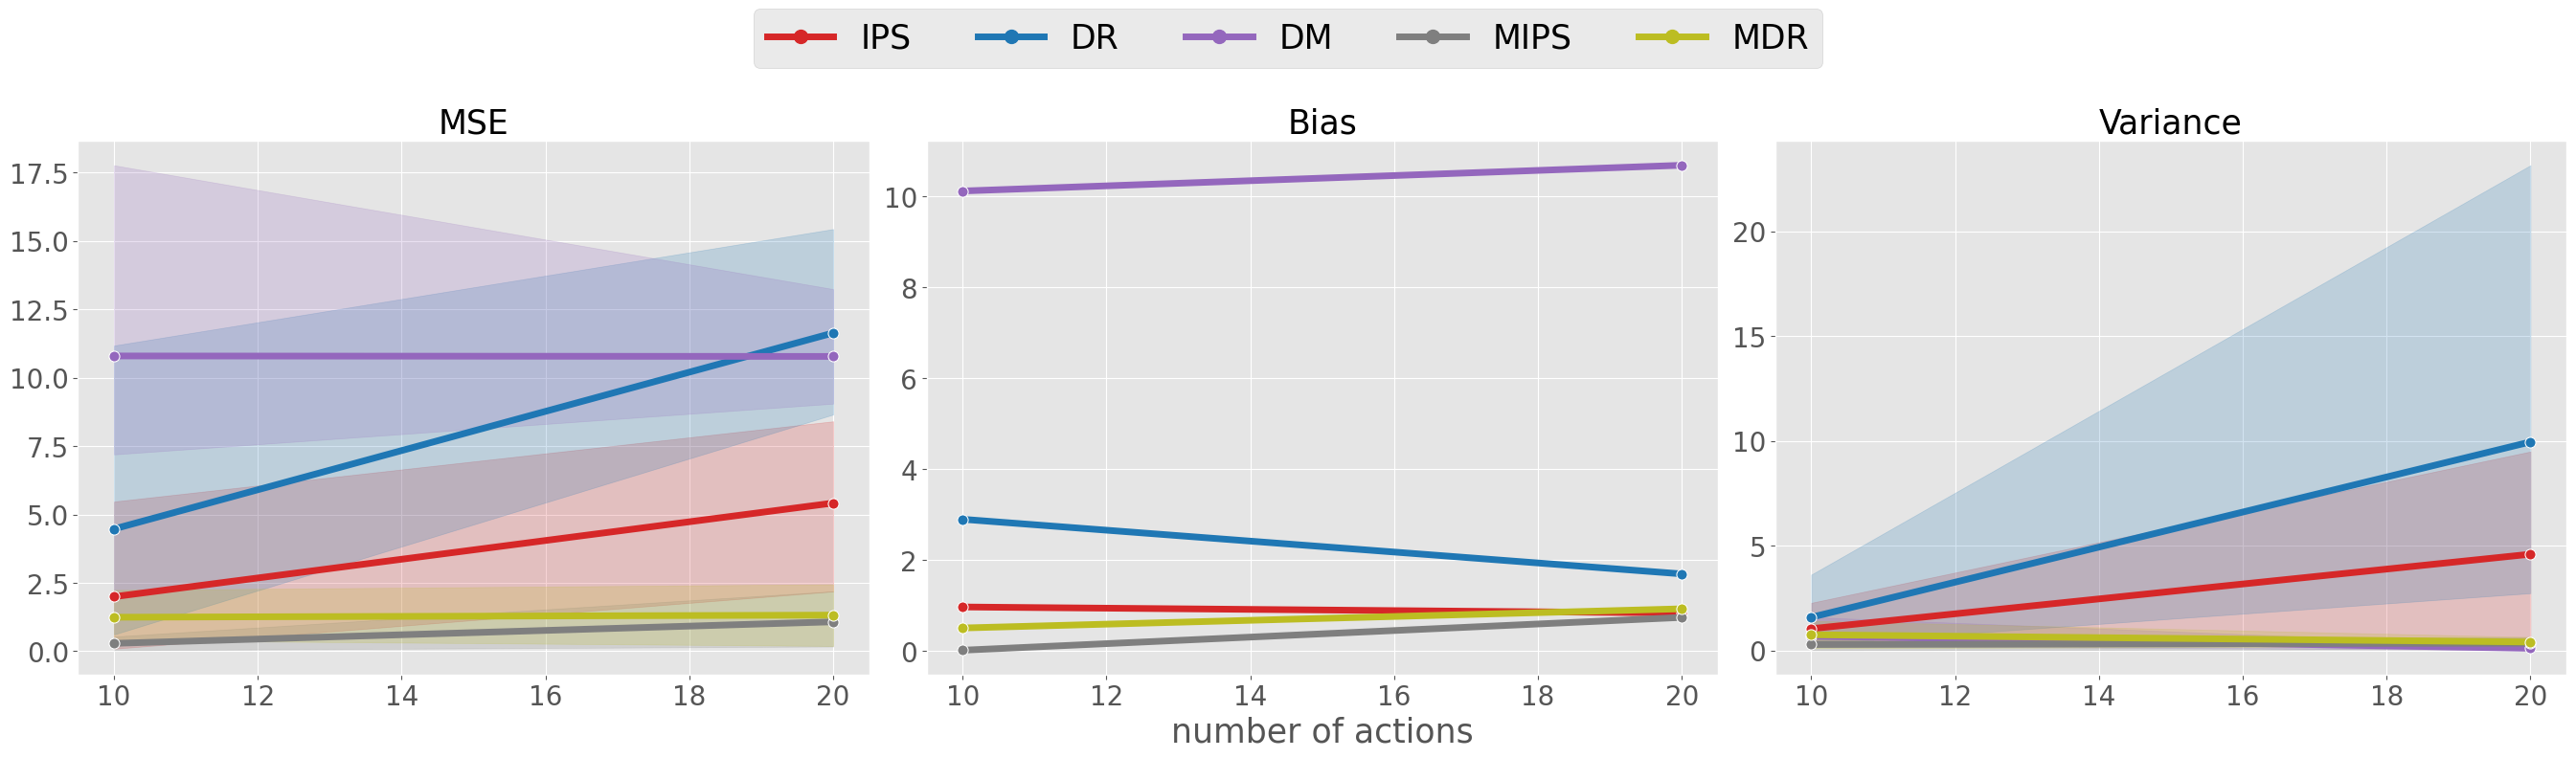

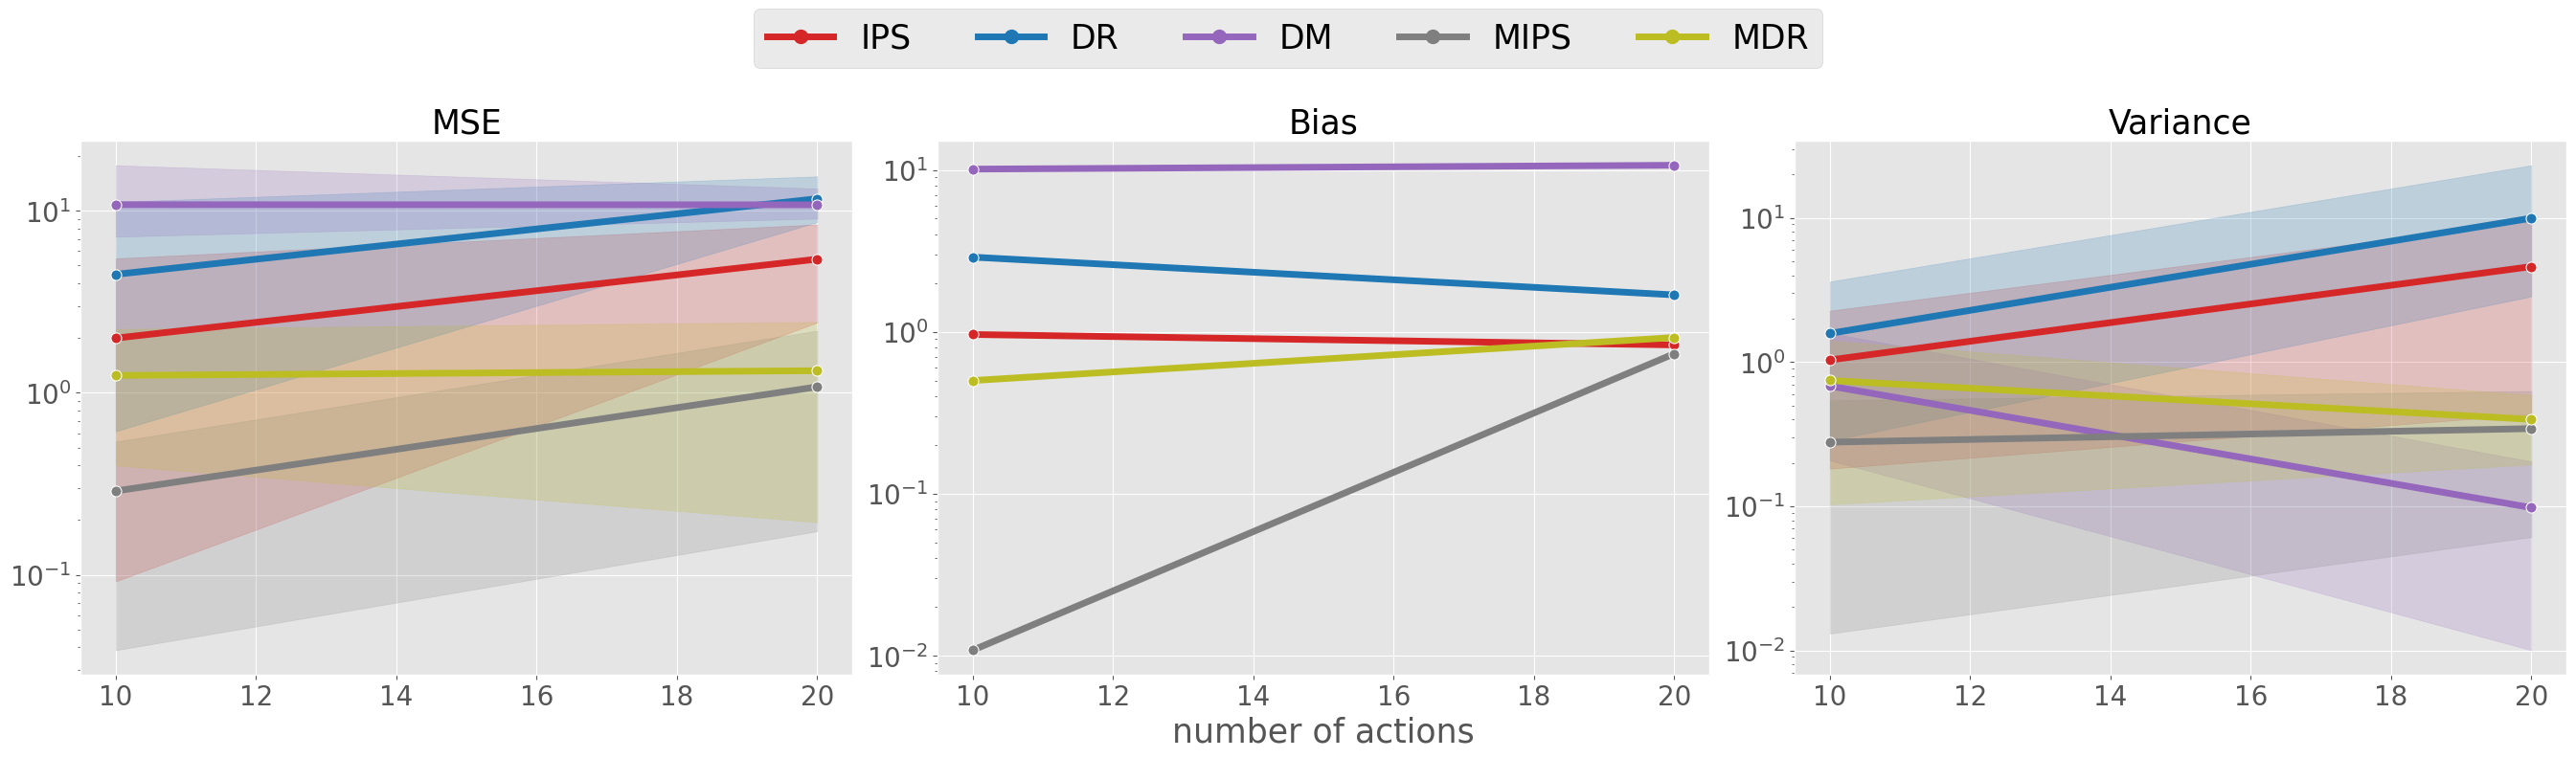

In [56]:
for flag_log_scale in [False, True]:
    plot_line(
        result_df = result_df, 
        x = x, 
        xlabel = xlabel, 
        flag_log_scale=flag_log_scale, 
        flag_share_y_scale=False,
    )